

<p><img height="80px" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Escudo/EscUpm.jpg" align="left" hspace="0px" vspace="0px"></p>

**Course "Artificial Neural Networks and Deep Learning" - Universidad Politécnica de Madrid (UPM)**

# **Deep Q-Learning for Cartpole**

This notebook includes an implementation of the Deep Q-learning (DQN) algorithm for the cartpole problem (see [OpenAI's Cartpole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/)).


##Libraries

In [1]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time
import random
import gc

## Hyperparameters

In [2]:
GAMMA = 0.99
MEMORY_SIZE = 40000
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EXPLORATION_MAX = 1
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995
NUMBER_OF_EPISODES = 1000
MAX_STEPS = 1000
USE_TARGET = False
LAST_N_SCORES = 30
STEPS_TO_UPDATE = 100
STEPS_TO_LEARN = 4
STEPS_TO_EXPLORE = 40000

## Class ReplayMemory

Memory of transitions for experience replay.

In [3]:
class ReplayMemory:

    def __init__(self,number_of_observations):
        # Create replay memory
        self.states = np.zeros((MEMORY_SIZE, number_of_observations))
        self.states_next = np.zeros((MEMORY_SIZE, number_of_observations))
        self.actions = np.zeros(MEMORY_SIZE, dtype=np.int32)
        self.rewards = np.zeros(MEMORY_SIZE)
        self.terminal_states = np.zeros(MEMORY_SIZE, dtype=bool)
        self.current_size=0
        self.max_size_reached = False

    def store_transition(self, state, action, reward, state_next, terminal_state):
        # Store a transition (s,a,r,s') in the replay memory
        i = self.current_size
        self.states[i] = state
        self.states_next[i] = state_next
        self.actions[i] = action
        self.rewards[i] = reward
        self.terminal_states[i] = terminal_state
        self.current_size = i + 1
        if self.current_size >= MEMORY_SIZE:
            self.current_size = 0
            self.max_size_reached = False

    def sample_memory(self, batch_size):
        # Generate a sample of transitions from the replay memory
        if self.max_size_reached:
            batch = np.random.choice(MEMORY_SIZE-1, batch_size)
        else:
            batch = np.random.choice(self.current_size, batch_size)
        states = self.states[batch]
        states_next = self.states_next[batch]
        rewards = self.rewards[batch]
        actions = self.actions[batch]   
        terminal_states = self.terminal_states[batch]  
        return states, actions, rewards, states_next, terminal_states

## Class DQN

Reinforcement learning agent with a Deep Q-Network.

In [4]:
class DQN:

    def __init__(self, number_of_observations, number_of_actions, use_target=True):
        # Initialize variables and create neural model
        self.exploration_rate = EXPLORATION_MAX
        self.use_target = use_target
        self.number_of_actions = number_of_actions
        self.number_of_observations = number_of_observations
        self.scores = []
        self.memory = ReplayMemory(number_of_observations)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        
    def remember(self, state, action, reward, next_state, terminal_state):
        # Store a tuple (s, a, r, s') for experience replay
        state = np.reshape(state, [1, self.number_of_observations])
        next_state = np.reshape(next_state, [1, self.number_of_observations])
        self.memory.store_transition(state, action, reward, next_state, terminal_state)

    def select(self, state):
        # Generate an action for a given state using epsilon-greedy policy
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.number_of_actions)
        else:
            state = np.reshape(state, [1, self.number_of_observations])
            q_values = self.model.predict(state, verbose=0)
            return np.argmax(q_values[0])

    def learn(self):
        # Learn the value Q using a sample of examples from the replay memory
        if self.memory.current_size < BATCH_SIZE: return

        states, actions, rewards, next_states, terminal_states = self.memory.sample_memory(BATCH_SIZE)
        
        if self.use_target:
            q_targets = self.target_model.predict(states, verbose=0)
            q_next_states = self.target_model.predict(next_states, verbose=0)
        else:
            q_targets = self.model.predict(states, verbose=0)
            q_next_states = self.model.predict(next_states, verbose=0)

        for i in range(BATCH_SIZE):
             if (terminal_states[i]):
                  q_targets[i][actions[i]] = rewards[i]
             else:
                  q_targets[i][actions[i]] = rewards[i] + GAMMA * np.max(q_next_states[i])    

        self.model.train_on_batch(states, q_targets)

        # Decrease exploration rate
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
       # Add the obtained score in a list to be presented later
        self.scores.append(score)

    def display_scores_graphically(self, file_name=None):
        # Display the obtained scores graphically
        plt.plot(self.scores)
        plt.xlabel("Episode")
        plt.ylabel("Score")
        if file_name is not None:
            plt.savefig(file_name)
    
    def create_model(self):
        # Creates the models
        model = keras.models.Sequential()
        n_hidden = [64]
        model.add(keras.layers.Dense(64, input_shape=(number_of_observations,), \
                             kernel_initializer="he_normal",
                             kernel_regularizer=keras.regularizers.L2(0.001)))
        model.add(keras.layers.Activation("relu"))
        for neurons in n_hidden:
            model.add(keras.layers.Dense(neurons,
                                         kernel_initializer="he_normal",
                                         kernel_regularizer=keras.regularizers.L2(0.001)))
            model.add(keras.layers.Activation("relu"))
                  
        model.add(keras.layers.Dense(number_of_actions, activation="linear"))
        model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))
        return model
    
    def update_target_model(self):
        if (self.use_target):
            print("Updating target model weights")
            self.target_model.set_weights(self.model.get_weights())
        
    def save_model(self, model_name):
        self.model.save(model_name)
    
    def get_mean_last_n_scores(self, n):
        scores_list = self.scores[-n:]
        np_scores = np.array(scores_list)
        scores_mean = np.mean(np_scores, axis=0)
        return scores_mean
    
    def reset_exploration(self):
        self.exploration_rate = EXPLORATION_MAX

## Environment Lunar Lander

Lunar Lander simulator from Open Ai Gym:

<p><img height="200px" src="https://raw.githubusercontent.com/martin-molina/reinforcement_learning/main/images/cartpole_attributes.png" align="center" vspace="20px"</p>

State vector:
- state[0]: position
- state[1]: velocity
- state[2]: angle
- state[3]: angular velocity

Actions:
- 0 (push cart to the left)
- 1 (push cart to the right)

In [5]:
def create_environment(render=False):
    # Create simulated environment
    if render:
        environment = gym.make("LunarLander-v2", render_mode="human")
    else:
        environment = gym.make("LunarLander-v2")
    number_of_observations = environment.observation_space.shape[0]
    number_of_actions = environment.action_space.n
    return environment, number_of_observations, number_of_actions

## Main program




We add episode score, the episode score will be equal to the sum of rewards in each step of the episode.

Episode   1: score -127.99077531155179 (exploration rate: 0.91, transitions: 106, time  6 )
Episode   2: score -128.14047358525684 (exploration rate: 0.81, transitions: 198, time  4 )
Episode   3: score -210.81312583033616 (exploration rate: 0.70, transitions: 319, time  7 )
Episode   4: score -315.26377680690723 (exploration rate: 0.63, transitions: 402, time  5 )
Episode   5: score -396.14603077298335 (exploration rate: 0.52, transitions: 549, time  9 )
Episode   6: score -70.77928928732746 (exploration rate: 0.45, transitions: 673, time  8 )
Episode   7: score -27.357709419004536 (exploration rate: 0.39, transitions: 793, time  8 )
Episode   8: score -238.93098236315484 (exploration rate: 0.32, transitions: 943, time  11 )
Episode   9: score -200.23205450011767 (exploration rate: 0.27, transitions: 1072, time  9 )
Episode  10: score -407.22748469373755 (exploration rate: 0.21, transitions: 1267, time  14 )
Episode  11: score -283.37579999386924 (exploration rate: 0.18, transitions: 

Episode  89: score 43.09327719783636 (exploration rate: 0.01, transitions: 9845, time  81 )
Episode  90: score -61.87884766338612 (exploration rate: 0.01, transitions: 10845, time  82 )
Episode  91: score 183.26443124733288 (exploration rate: 0.01, transitions: 11538, time  56 )
Episode  92: score 75.97477900577125 (exploration rate: 0.01, transitions: 12538, time  81 )
Episode  93: score 32.54768167063963 (exploration rate: 0.01, transitions: 13538, time  81 )
Episode  94: score -431.6357334978715 (exploration rate: 0.01, transitions: 14335, time  65 )
Episode  95: score -50.75107298185363 (exploration rate: 0.01, transitions: 15335, time  81 )
Episode  96: score -98.81204470822827 (exploration rate: 0.01, transitions: 16011, time  55 )
Episode  97: score -15.76639396408456 (exploration rate: 0.01, transitions: 17011, time  81 )
Episode  98: score 45.58091125963592 (exploration rate: 0.01, transitions: 18011, time  81 )
Episode  99: score -16.57310138850433 (exploration rate: 0.01, tr

Episode 177: score 193.29303264051924 (exploration rate: 0.01, transitions: 39830, time  56 )
Episode 178: score -212.65129151476796 (exploration rate: 0.01, transitions: 55, time  17 )
Episode 179: score -293.13014871256496 (exploration rate: 0.96, transitions: 209, time  11 )
Episode 180: score -249.2701560466233 (exploration rate: 0.85, transitions: 309, time  5 )
Episode 181: score -71.66982273766709 (exploration rate: 0.77, transitions: 389, time  4 )
Episode 182: score -165.55252087768645 (exploration rate: 0.68, transitions: 493, time  6 )
Episode 183: score -164.50790596745577 (exploration rate: 0.53, transitions: 687, time  12 )
Episode 184: score -258.7744848214394 (exploration rate: 0.37, transitions: 975, time  19 )
Episode 185: score -79.44148524190058 (exploration rate: 0.21, transitions: 1436, time  33 )
Episode 186: score -1012.2455097156634 (exploration rate: 0.15, transitions: 1691, time  19 )
Episode 187: score -493.3205090521761 (exploration rate: 0.13, transitions:

Episode 265: score -84.67322294112742 (exploration rate: 0.01, transitions: 8974, time  81 )
Episode 266: score 63.46742388029705 (exploration rate: 0.01, transitions: 9974, time  81 )
Episode 267: score 236.92319352766373 (exploration rate: 0.01, transitions: 10641, time  54 )
Episode 268: score 8.941050726792326 (exploration rate: 0.01, transitions: 10839, time  16 )
Episode 269: score -102.57732186345068 (exploration rate: 0.01, transitions: 11839, time  81 )
Episode 270: score -19.354249843106977 (exploration rate: 0.01, transitions: 12839, time  81 )
Episode 271: score -246.33911076305628 (exploration rate: 0.01, transitions: 13324, time  39 )
Episode 272: score 3.333678153953497 (exploration rate: 0.01, transitions: 14324, time  81 )
Episode 273: score -319.38879216116806 (exploration rate: 0.01, transitions: 14438, time  9 )
Episode 274: score -139.88031540646014 (exploration rate: 0.01, transitions: 15086, time  52 )
Episode 275: score -612.1739890820947 (exploration rate: 0.01

Episode 353: score -122.44460005913744 (exploration rate: 0.01, transitions: 25625, time  54 )
Episode 354: score -36.423462942629634 (exploration rate: 0.01, transitions: 26625, time  81 )
Episode 355: score 247.44574555567357 (exploration rate: 0.01, transitions: 26981, time  30 )
Episode 356: score -41.81579436943884 (exploration rate: 0.01, transitions: 27981, time  87 )
Episode 357: score 6.861390770600285 (exploration rate: 0.01, transitions: 28981, time  84 )
Episode 358: score 205.0528181122537 (exploration rate: 0.01, transitions: 29441, time  37 )
Episode 359: score 194.90315286651327 (exploration rate: 0.01, transitions: 30232, time  72 )
Episode 360: score 173.2609957615402 (exploration rate: 0.01, transitions: 30719, time  42 )
Episode 361: score 261.89248270722436 (exploration rate: 0.01, transitions: 31227, time  43 )
Episode 362: score -2.201241131313835 (exploration rate: 0.01, transitions: 32227, time  86 )
Episode 363: score 204.43004709719855 (exploration rate: 0.01

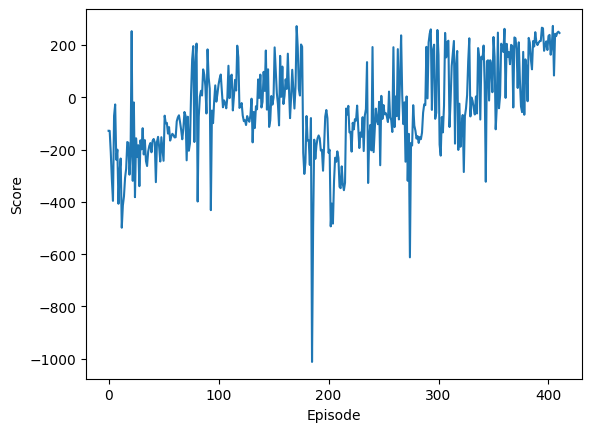

In [6]:
environment, number_of_observations, number_of_actions = create_environment(render=True)
agent = DQN(number_of_observations, number_of_actions, use_target=USE_TARGET)
episode = 0
goal_reached = False
start_time = time.perf_counter()

update_countdown = STEPS_TO_UPDATE
learn_countdown = STEPS_TO_LEARN
explore_countdown = STEPS_TO_EXPLORE

while (episode < NUMBER_OF_EPISODES) and not (goal_reached):
    start_episode_time = time.perf_counter()
    episode += 1
    episode_score = 0
    step = 1
    end_episode = False
    state = environment.reset()[0]
    
    while not(end_episode):
        # Select an action for the current state
        action = agent.select(state)
        # Execute the action in the environment
        state_next, reward, terminal_state, truncated, info = environment.step(action)
        
        # Update score:
        episode_score += reward
        # Store in memory the transition (s,a,r,s') 
        agent.remember(state, action, reward, state_next, terminal_state)

        # Learn using a batch of experience stored in memory
        if (learn_countdown <= 0):
            agent.learn()
            learn_countdown = STEPS_TO_LEARN
        # Detect end of episode and print
        if terminal_state or step >= MAX_STEPS:
            agent.add_score(episode_score)
            scores_mean = agent.get_mean_last_n_scores(LAST_N_SCORES)
            if scores_mean >= 200: goal_reached = True
            print("Episode {0:>3}: ".format(episode), end = '')
            print("score {0:>3} ".format(episode_score), end = '') 
            print("(exploration rate: %.2f, " % agent.exploration_rate, end = '')
            print("transitions:", str(agent.memory.current_size), end = ', ')
            print("time ", round(time.perf_counter() - start_episode_time), ")" )
            end_episode = True 
        else:
            state = state_next
            step += 1
            update_countdown -= 1
            learn_countdown -= 1
            explore_countdown -= 1
            
        if update_countdown <= 0:
            agent.update_target_model()
            update_countdown = STEPS_TO_UPDATE
            
        if explore_countdown <= 0:
            agent.reset_exploration()
            explore_countdown = STEPS_TO_EXPLORE
    
    gc.collect()
    tf.keras.backend.clear_session()
        
if goal_reached: print("Reached goal sucessfully.")
else: print("Failure to reach the goal.")

total_time = round((time.perf_counter() - start_time)/60)
print ("Time:", total_time, "minutes")

environment.close()
agent.display_scores_graphically()

## Save model and experiment results

In [7]:
import pandas as pd

model_name = 'model24_64_12_nodr_nobn'
COLUMNS = [
    'model_name',
    'gamma',
    'memory_size',
    'learning_rate',
    'batch_size',
    'exploration_max',
    'exploration_min',
    'exploration_decay',
    'number_of_episodes',
    'max_steps',
    'use_target',
    'training_time',
    'used_episodes',
    'goal_reached',
    'last_n_scores',
    'steps_to_update',
    'scores_mean',
    'steps_to_learn',
    'steps_to_explore'
]

experiment_result = [[
    model_name,
    GAMMA,
    MEMORY_SIZE,
    LEARNING_RATE,
    BATCH_SIZE,
    EXPLORATION_MAX,
    EXPLORATION_MIN,
    EXPLORATION_DECAY,
    NUMBER_OF_EPISODES,
    MAX_STEPS,
    USE_TARGET,
    total_time,
    episode,
    goal_reached,
    LAST_N_SCORES,
    STEPS_TO_UPDATE,
    agent.get_mean_last_n_scores(LAST_N_SCORES),
    STEPS_TO_LEARN,
    STEPS_TO_EXPLORE
]]

new_experiment_df = pd.DataFrame(experiment_result, columns=COLUMNS)

In [8]:
history_path = 'experiments_history.csv'
experiments_history_df = pd.read_csv(history_path, index_col=0)
concatenation = pd.concat([experiments_history_df, new_experiment_df], ignore_index=True)
concatenation.to_csv(history_path)

In [9]:
model_file_name = f"{model_name}.hdf5"
agent.save_model(model_file_name)

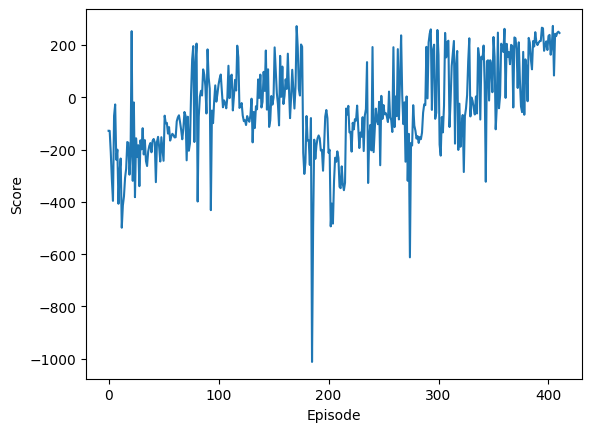

In [10]:
model_graph_name = f"{model_name}_training.png"
agent.display_scores_graphically(file_name=model_graph_name)